In [750]:
import re
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
%matplotlib inline


df = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")


df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [751]:
# VERY USEFUL METHOD
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Preprocessing

In [752]:
def feature_engineering(df):
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

    def get_title(name):
        title_search = re.search(' ([A-Za-z]+)\.', name)
        # If the title exists, extract and return it.
        if title_search:
            return title_search.group(1)
        return ""

    # Create a new feature Title, containing the titles of passenger names
    df['Title'] = df['Name'].apply(get_title)

    # Group all non-common titles into one single grouping "Rare"
    df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')

    ## create bin for age features
    df['Age_bin'] = pd.cut(df['Age'], bins=[0, 12, 20, 40, 120], labels=['Children', 'Teenage', 'Adult', 'Elder'])
    
    ## create bin for fare features
    df['Fare_bin'] = pd.cut(df['Fare'], bins=[0,7.91,14.45,31,120], labels=['Low_fare', 'median_fare', 'Average_fare', 'high_fare'])
    
    return df

def preprocess(df):
    # IMPORTANT TO CHECK if any columns has NaN values !!!!!!!
    df['Fare'].fillna(df['Fare'].median(), inplace=True)
    df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
    df['Age'].fillna(df['Age'].median(), inplace=True)

    # Feature Engineering
    df = feature_engineering(df)

    # One Hot Encoding
    df = pd.get_dummies(df, columns = ["Sex","Title","Age_bin","Embarked","Fare_bin"],
                             prefix=["Sex","Title","Age_type","Em_type","Fare_type"])

    # Scaling
    column_to_scale = ["Pclass", "Age", "Fare", "SibSp", "Parch", "FamilySize"]
    df[column_to_scale] = MinMaxScaler().fit_transform(df[column_to_scale])

    # Drop useless columns
    df.drop(['Age', 'Fare', 'Name', 'Ticket', 'Cabin', 'PassengerId'], axis=1, inplace=True)

    return df

In [753]:
df = preprocess(df)
X, y = df.drop("Survived", axis=1), df.Survived
X_test = preprocess(df_test)

check the nan value in train data
Pclass                    0
SibSp                     0
Parch                     0
FamilySize                0
Sex_female                0
Sex_male                  0
Title_Master              0
Title_Miss                0
Title_Mr                  0
Title_Mrs                 0
Title_Rare                0
Age_type_Children         0
Age_type_Teenage          0
Age_type_Adult            0
Age_type_Elder            0
Em_type_C                 0
Em_type_Q                 0
Em_type_S                 0
Fare_type_Low_fare        0
Fare_type_median_fare     0
Fare_type_Average_fare    0
Fare_type_high_fare       0
dtype: int64
__________________________________________________________________________________________
check the nan value in test data
Pclass                    0
SibSp                     0
Parch                     0
FamilySize                0
Sex_female                0
Sex_male                  0
Title_Master              0
Title_Miss       

In [754]:
X.shape, y.shape

((891, 22), (891,))

In [755]:
X.describe()

,Pclass,SibSp,Parch,FamilySize,Sex_female,Sex_male,Title_Master,Title_Miss,Title_Mr,Title_Mrs,...,Age_type_Teenage,Age_type_Adult,Age_type_Elder,Em_type_C,Em_type_Q,Em_type_S,Fare_type_Low_fare,Fare_type_median_fare,Fare_type_Average_fare,Fare_type_high_fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,...,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.654321,0.065376,0.063599,0.090460,0.352413,0.647587,0.044893,0.207632,0.580247,0.141414,...,0.123457,0.630752,0.168350,0.188552,0.086420,0.725028,0.233446,0.243547,0.257015,0.206510
std,0.418036,0.137843,0.134343,0.161346,0.477990,0.477990,0.207186,0.405840,0.493796,0.348644,...,0.329146,0.482872,0.374387,0.391372,0.281141,0.446751,0.423261,0.429463,0.437233,0.405028
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.125000,0.000000,0.100000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Build ANN model (77.033%)


In [756]:
model = keras.Sequential([
    keras.layers.Dense(22, input_dim=22, activation="relu"),
    keras.layers.Dense(13, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid"),
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [757]:
model.fit(X, y, epochs=500)

5
Epoch 303/500
28/28 [==============================] - 0s 2ms/step - loss: 0.3006 - accuracy: 0.8765
Epoch 304/500
28/28 [==============================] - 0s 2ms/step - loss: 0.3001 - accuracy: 0.8777
Epoch 305/500
28/28 [==============================] - 0s 2ms/step - loss: 0.2991 - accuracy: 0.8743
Epoch 306/500
28/28 [==============================] - 0s 2ms/step - loss: 0.2964 - accuracy: 0.8777
Epoch 307/500
28/28 [==============================] - 0s 2ms/step - loss: 0.2970 - accuracy: 0.8810
Epoch 308/500
28/28 [==============================] - 0s 3ms/step - loss: 0.2969 - accuracy: 0.8754
Epoch 309/500
28/28 [==============================] - 0s 2ms/step - loss: 0.2984 - accuracy: 0.8788
Epoch 310/500
28/28 [==============================] - 0s 1ms/step - loss: 0.2989 - accuracy: 0.8777
Epoch 311/500
28/28 [==============================] - 0s 1ms/step - loss: 0.2970 - accuracy: 0.8788
Epoch 312/500
28/28 [==============================] - 0s 2ms/step - loss: 0.2991 - accur

In [758]:
y_pred = model.predict(X_test)

y_pred = np.round(y_pred)
y_pred = np.concatenate((np.reshape(range(892, 1310), (-1, 1)), y_pred), axis=1).astype("int")

df_result = pd.DataFrame(data=y_pred, columns=["PassengerId", "Survived"])
df_result.to_csv("result.csv", index=False)

df_result.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


## XGBoost (77.272%)

In [759]:
from xgboost import XGBClassifier
classifier = XGBClassifier()
classifier.fit(X, y)

y_pred = classifier.predict(X_test)
y_pred = np.concatenate((np.reshape(range(892, 1310), (-1, 1)), np.reshape(y_pred, (-1, 1))), axis=1).astype("int")

df_result = pd.DataFrame(data=y_pred, columns=["PassengerId", "Survived"])
df_result.to_csv("result_xgboost.csv", index=False)

[22:39:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
C:\ProgramData\Miniconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


## Catboost (74%)

In [760]:
from catboost import CatBoostClassifier, Pool
model = CatBoostClassifier(iterations=20,
                           depth=4,
                           learning_rate=1,
                           loss_function='Logloss',
                           verbose=False)
# train the model
model.fit(X, y)
# make the prediction using the resulting model
y_pred = model.predict(X_test)
y_pred = np.concatenate((np.reshape(range(892, 1310), (-1, 1)), np.reshape(y_pred, (-1, 1))), axis=1).astype("int")

df_result = pd.DataFrame(data=y_pred, columns=["PassengerId", "Survived"])
df_result.to_csv("result_catboost.csv", index=False)

## Random Forests (75%)

Important features
____________________________________________________________
89.11


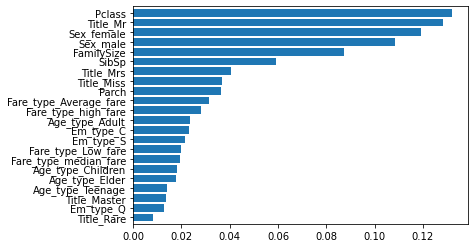

In [761]:

from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
random_forest.fit(X, y)
Y_pred_rf = random_forest.predict(X_test)
acc_random_forest = round(random_forest.score(X, y) * 100, 2)

print("Important features")
pd.Series(random_forest.feature_importances_, X.columns).sort_values(ascending=True).plot.barh(width=0.8)
print('__'*30)
print(acc_random_forest)

In [762]:
df_result = pd.DataFrame({"PassengerId": range(892, 1310), "Survived": Y_pred_rf})
df_result.to_csv("result_RandomForest.csv", index=False)

## Another random Forest

In [768]:
model = RandomForestClassifier(n_estimators=2000, min_samples_leaf=3, max_features=0.5, n_jobs=-1)
model.fit(X, y)
model.score(X, y)
y_pred = model.predict(X_test)

In [769]:
df_result = pd.DataFrame({"PassengerId": range(892, 1310), "Survived": y_pred})
df_result.to_csv("result_RandomForest_2.csv", index=False)